# EDA & Feature selection

## Abstract

This notebook aims at:
- making a first batch of data explorations on the train dataset,
- highlighting the potential discrepancies,
- making a feature selection,
- exploring some potential features vs. the target variable.

## Train data exploration

The train data size is a 24 MB CSV file - which is hosted in Cloud Storage.
<br>We will load the entire dataset in the notebook and run some EDA tools ecosystem (e.g. SweetViz) to assess descriptive statistics.

<br>__Caution is taken that we will focus on the sole purpose of our machine learning task: _predicting the purchase amount from the customer purchase patterns data available_.__

### Load data

In [1]:
import pandas as pd

# TODO: Upload data to GCS
train_data = pd.read_csv('D:/Data/BlackFriday/train.csv')

In [2]:
train_data.shape

(550068, 12)

In [3]:
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


There are 550,068 transactional records and 12 columns:
- two identifiers `User_ID` & `Product_ID`
- some customer demographics metadata: `Gender`, `Age`, `City_Category`, `Stay_In_Current_City_Years`
- some customer social metadata: `Marital_Status`, `Occupation`
- some customer purchase data: `Product_Category_1`, `Product_Category_2`, `Product_Category_3`
- the purchase amount related to a transaction.

### Check the types

In [4]:
train_data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

Actually all variables - except `Purchase` & maybe `Stay_In_Current_City_Years` - should be categorical.

Let's take a look at the variable `Stay_In_Current_City_Years`.

In [5]:
train_data['Stay_In_Current_City_Years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

There are 5 unique values, which should be numeric except the `4+` while the value `4` is not present.
<br>For a matter of ML, it does not make any difference to cap such variable strictly to the value `4`.

Let's keep the categorical nature of this variable for the data exploration but we will cast it to numeric for modelling.

In [6]:
categorical_variables = [c for c in train_data.columns if c not in ['Purchase']]

train_data[categorical_variables] = train_data[categorical_variables].astype('object')

### SweetViz

In [33]:
import time
import sweetviz

t0 = time.time()

train_report = sweetviz.analyze([train_data, "Train"], target_feat="Purchase")

print('Report creation time: {} sec'.format(time.time() - t0))

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)

Report creation time: 62.19327902793884 sec


Report train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



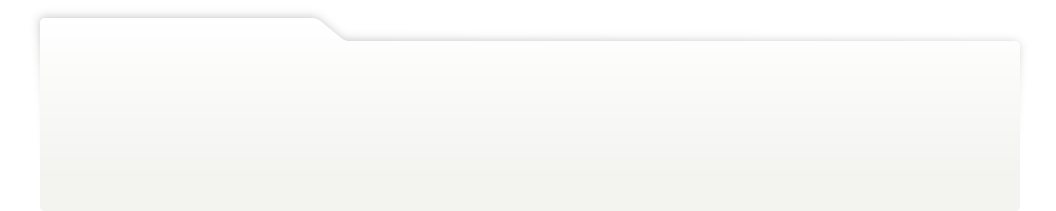
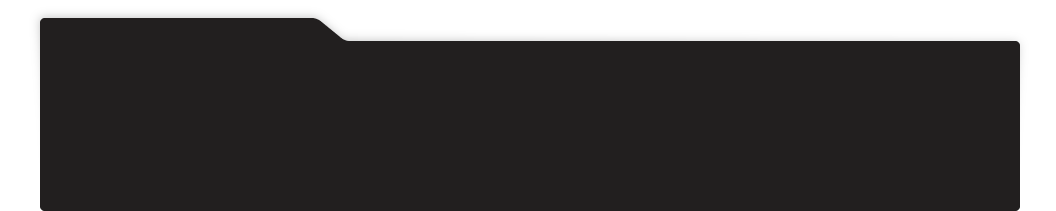
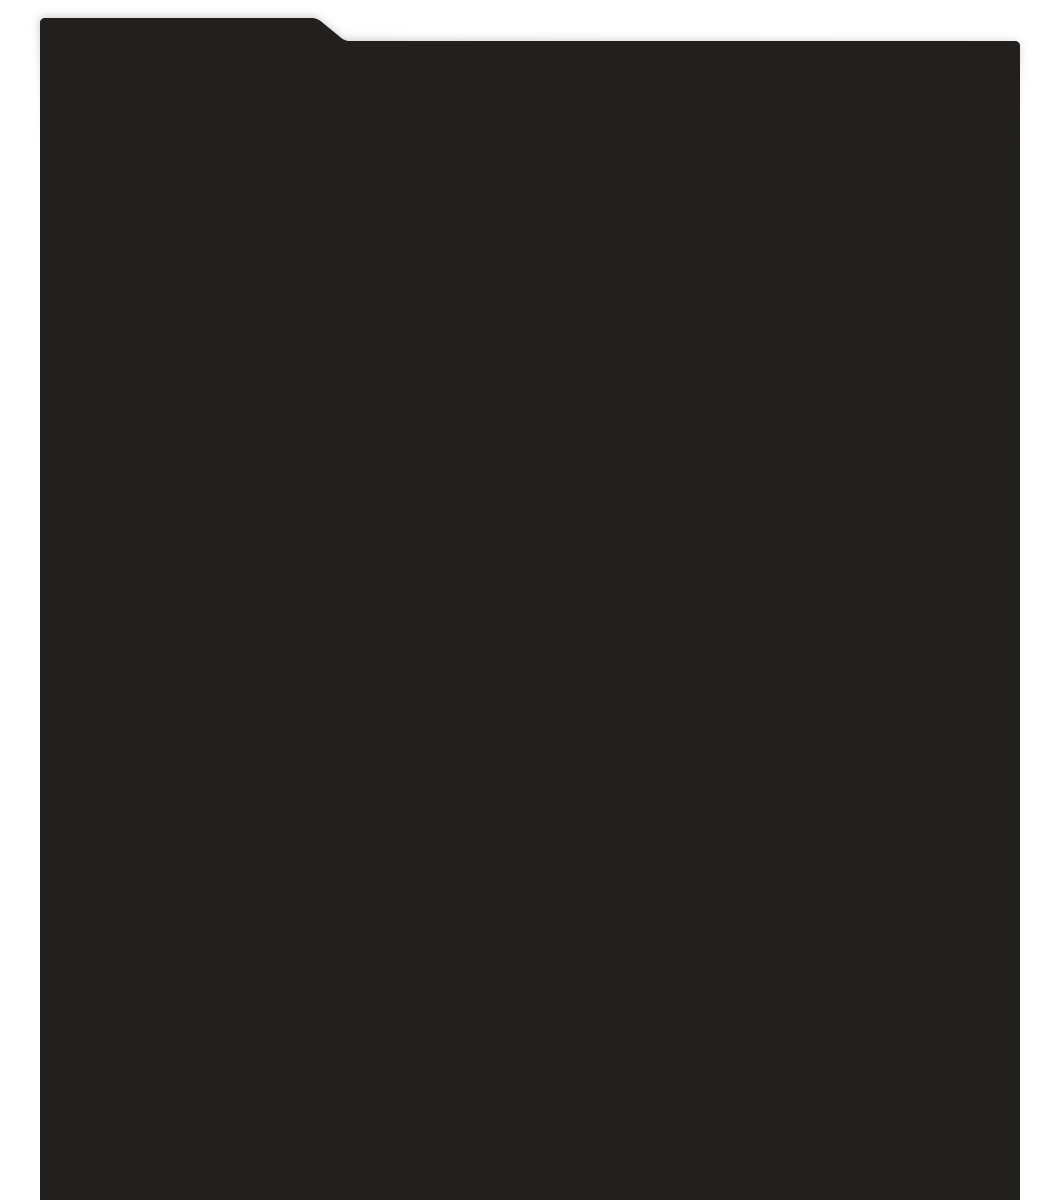
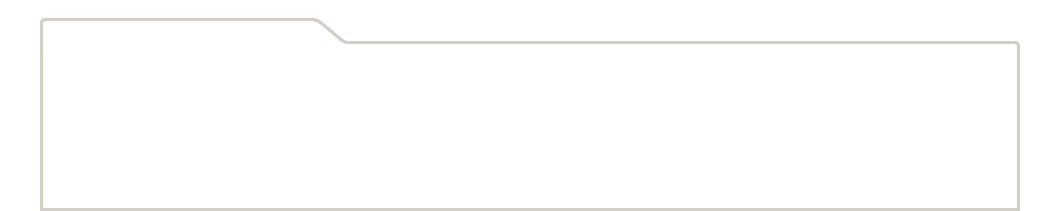
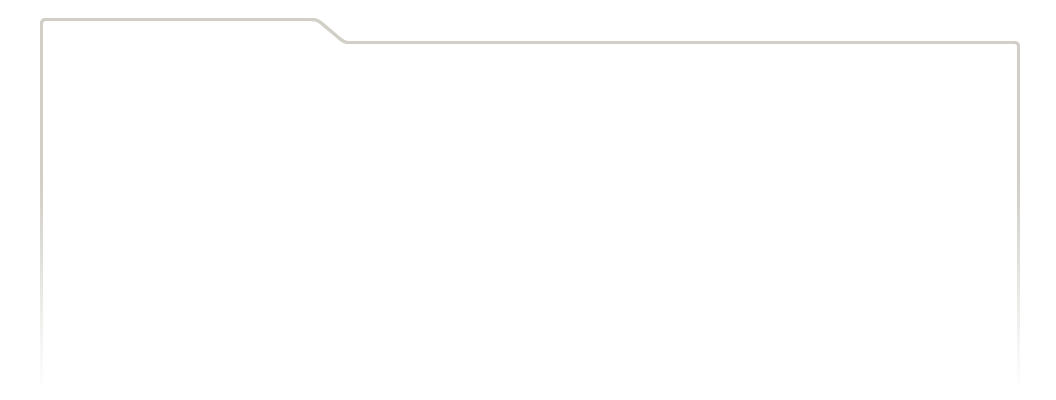
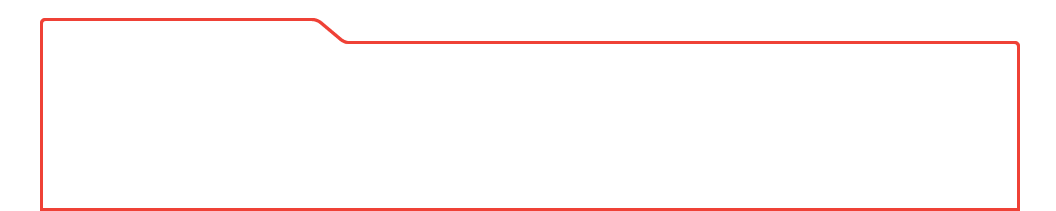
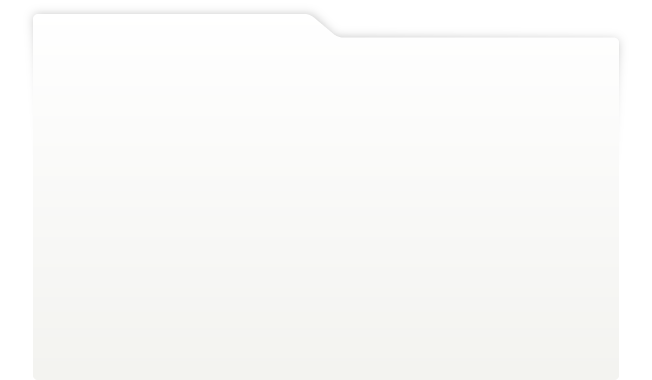
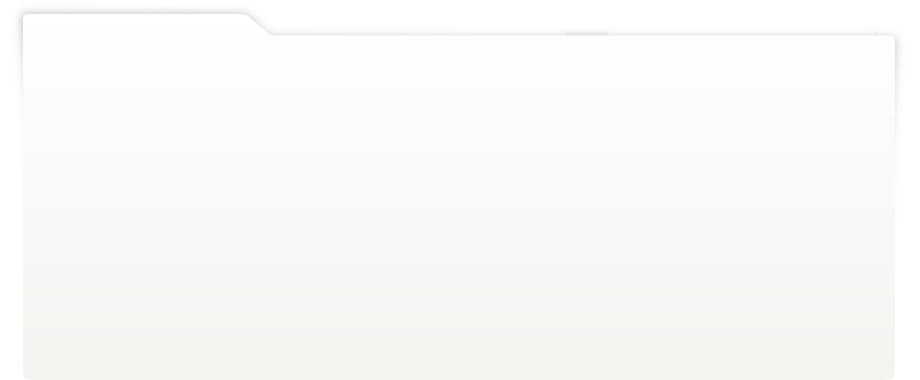
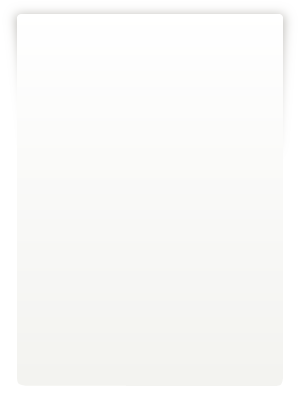
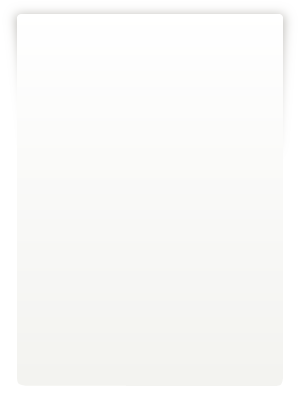
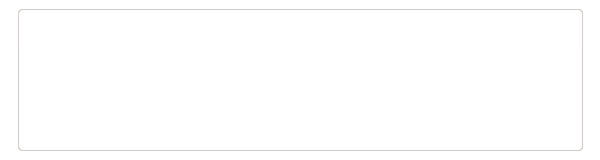
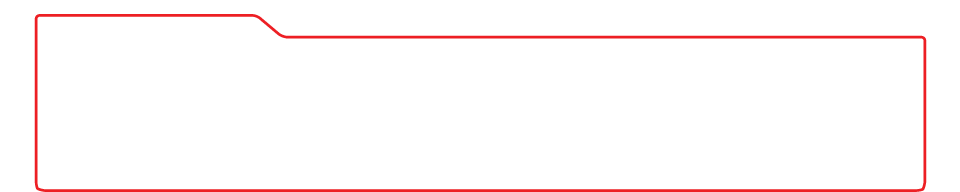
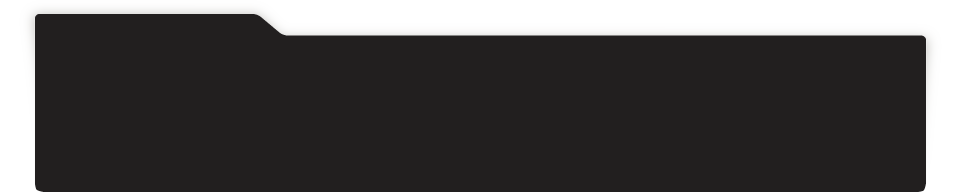
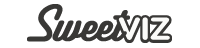
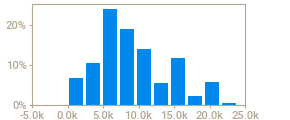
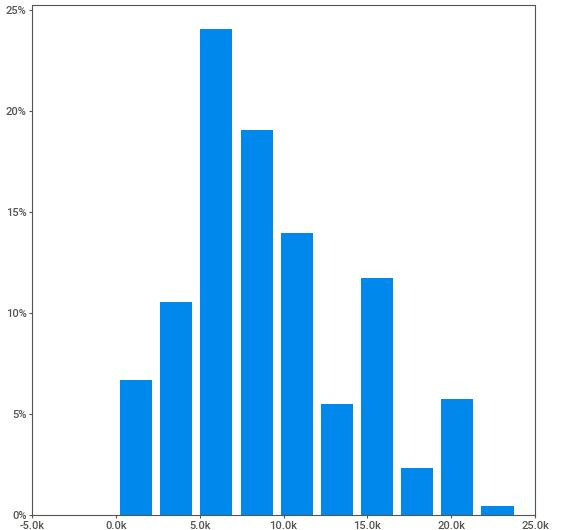
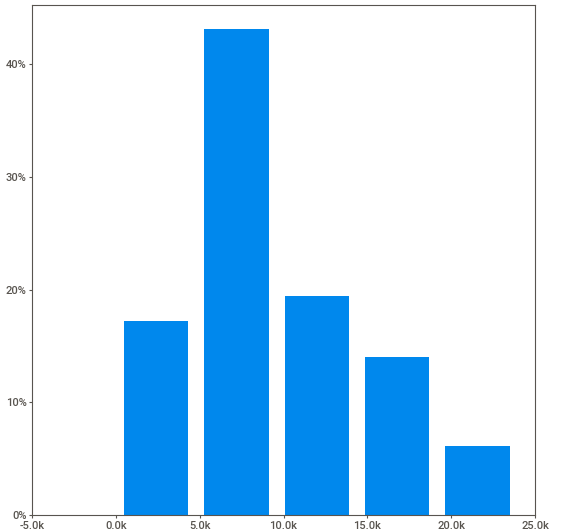
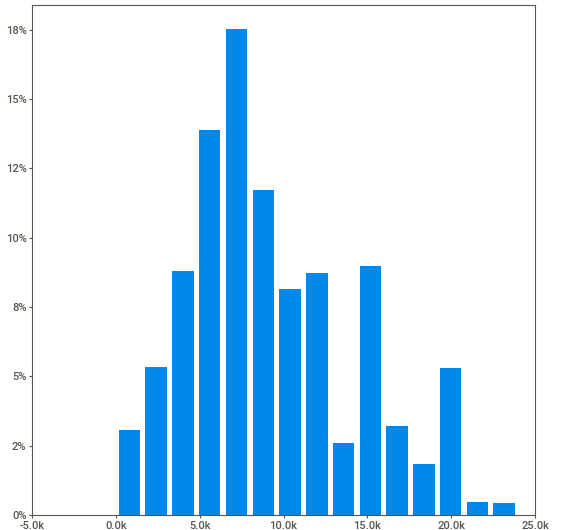
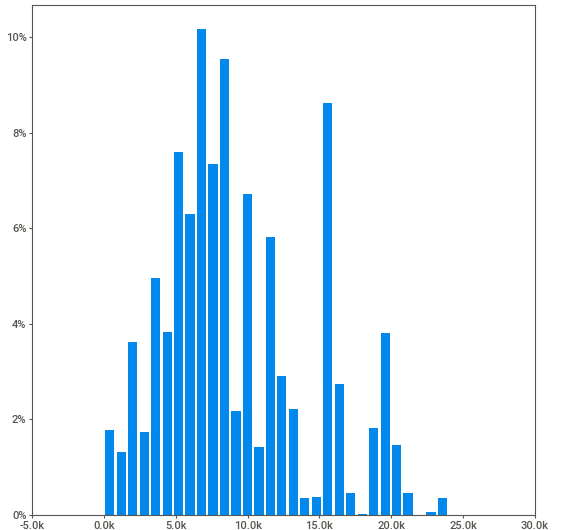
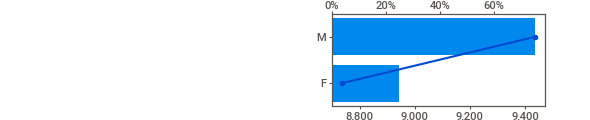
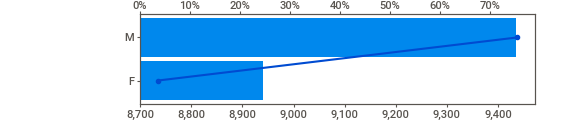
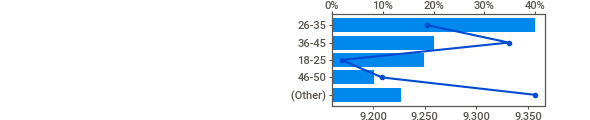
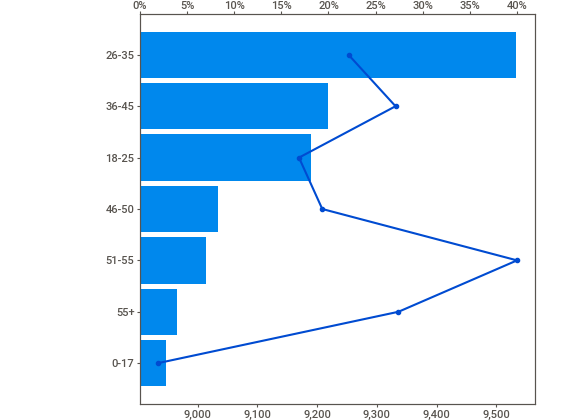
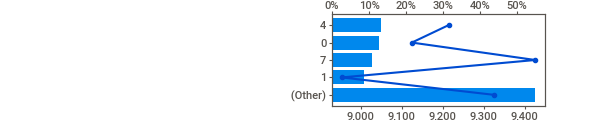
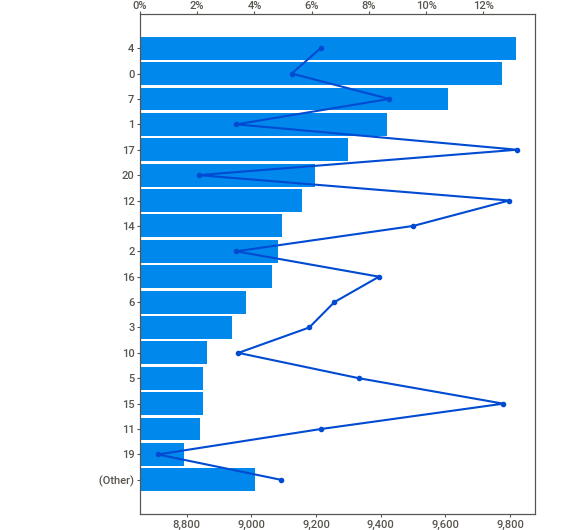
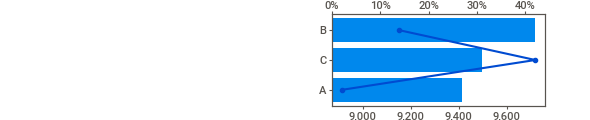
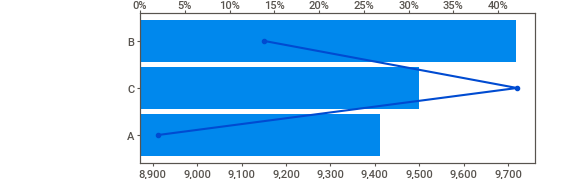
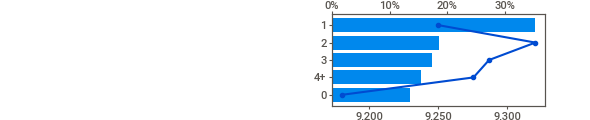
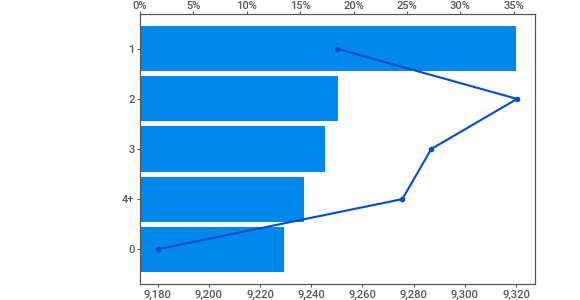
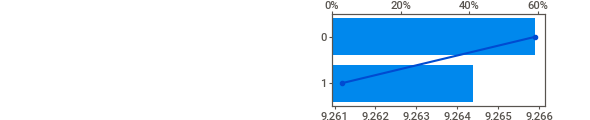
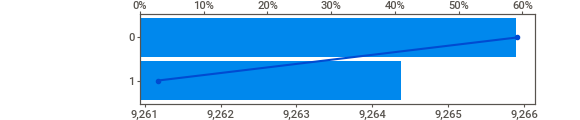
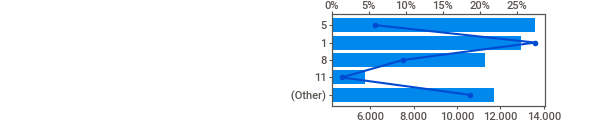
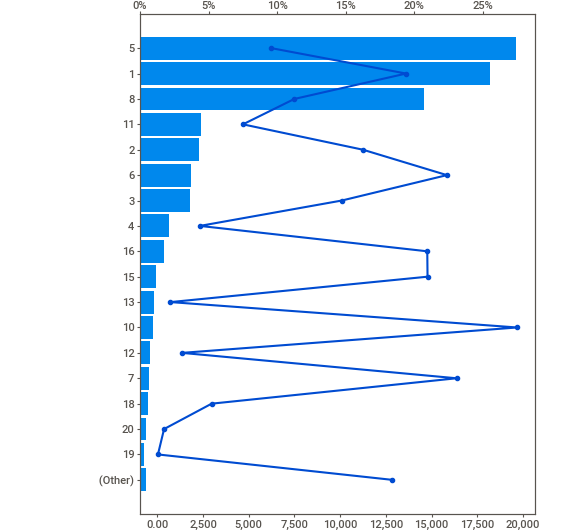
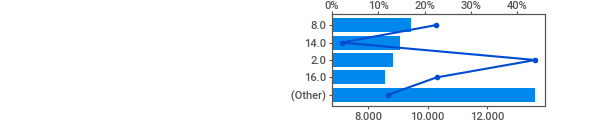
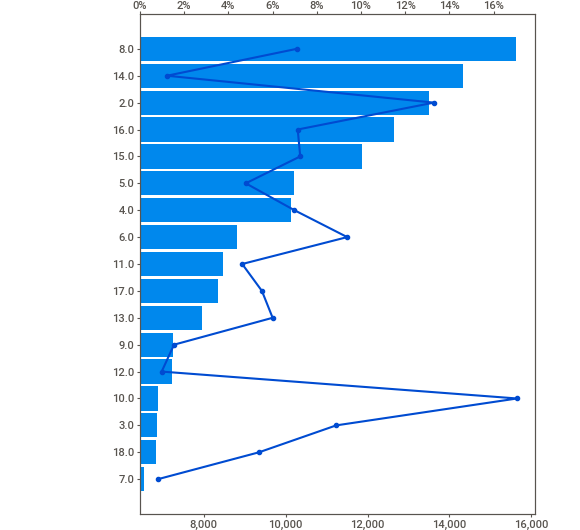
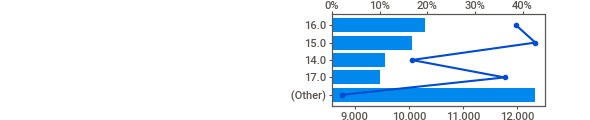
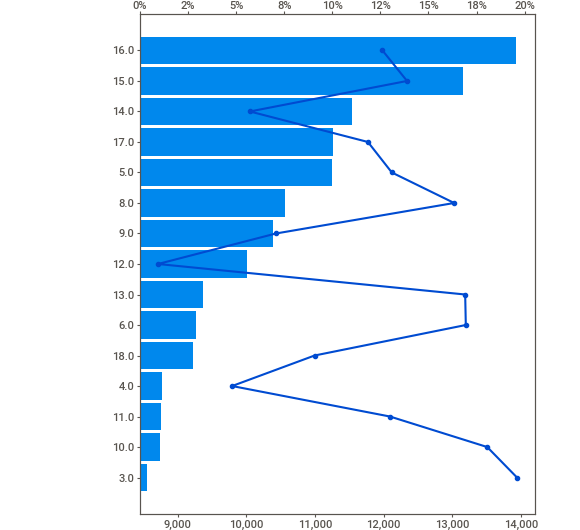
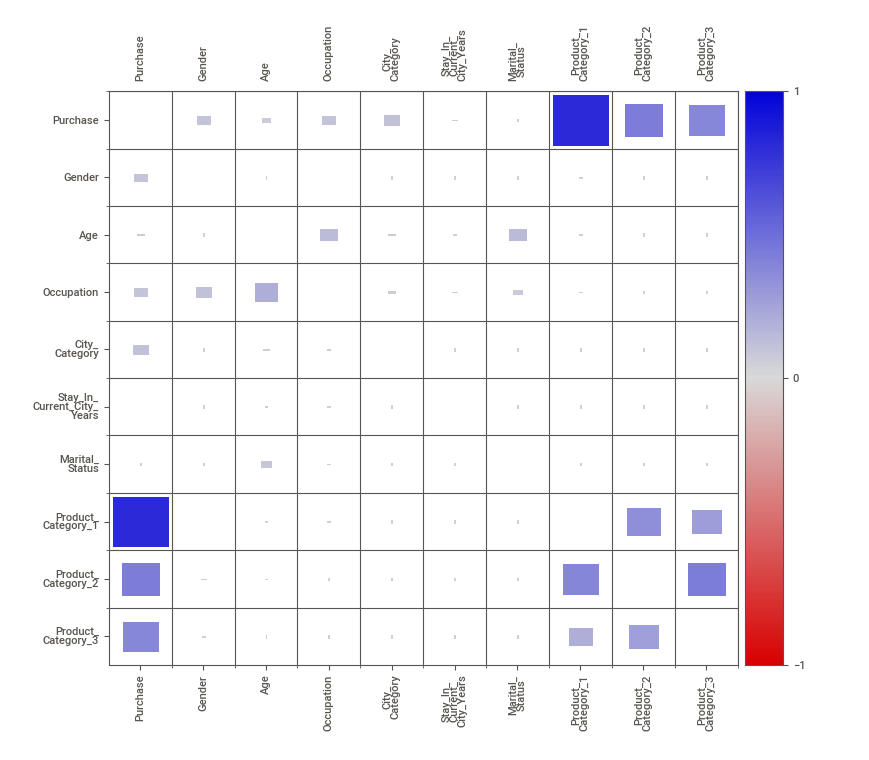
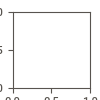

In [34]:
# Save report in a seperate file as well
train_report.show_html(filepath="train_report.html", open_browser=False)
train_report.show_notebook()

### Feature engineering

There are usually two approaches for feature engineering:
- a __top-down__ approach by leveraging domain knowledge & expertise and mimick them with new engineered features; such approach needs documentation & proper description of the initial data - _that we do not have here_
- a __bottom-up__ approach by creating features as statistics, aggregations, etc.; such approach works with numeric variables - _while we do have categorical variables here_

So the two approaches described above are not feasible in our use case.

A last way of making agnostic new features is simply to make some feature crosses.
<br>However in our use case, since we foresee to use ensembles of decision trees, such crosses are completely redundant; decision trees combine multiple features in their decision rules in a manner which is even more sophisticated than the crosses we could make.

### Feature selection

TODO

From the SweetViz report extracted above, we do not see many discrepancies:
- the ratios of 0s are normal;
- there are no missing values for most of the variables.

The only 2 discrepancies found are major nonetheless:
- `Product_Category_2` has 32% of missing values;
- `Product_Category_3` has 70% of missing values.

If we would like to use those two variables as features to predict the `Purchase` variable, imputing any numeric value is hazardous while it would not make sense to let so many entries as `"missing"` because of the very high ratios of missing values.
We will then drop those two variables: `Product_Category_2` & `Product_Category_3` from the rest of the ML use case.

All other variables - excl.`Purchase` - present no caveat to be considered as features for the ML task.

### Target variable: `Purchase`

The SweetViz report does not show any discrepancy in the target variable.

Its distribution is quite smooth and we have no reason to consider any outlier.

__Note: we do have no description of the target variable; we do not even know its unit, nor indeed the type of customers (individual vs. professional, etc.)__

### Feature vs. Target

For the remaining potential features - __with a low cardinality__, let's plot the distributions of `Purchase` when partitioned by each feature value.

Such features are:
- `Gender`
- `Age`
- `Occupation`
- `Marital_Status`
- `City_Category`
- `Stay_In_Current_City_Years`
- `Product_Category_1`
- TODO: `Product_Category_2`, `Product_Category_3`

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12, 6)})
sns.set(style="darkgrid")

def trace_partitioned(df, y=None, partition_by=None):
    for label_, df_ in df.groupby(partition_by):
        sns.kdeplot(df_[y], label=label_)

    plt.legend()
    plt.title('{} - partitioned by {}'.format(y, partition_by))
    plt.show()

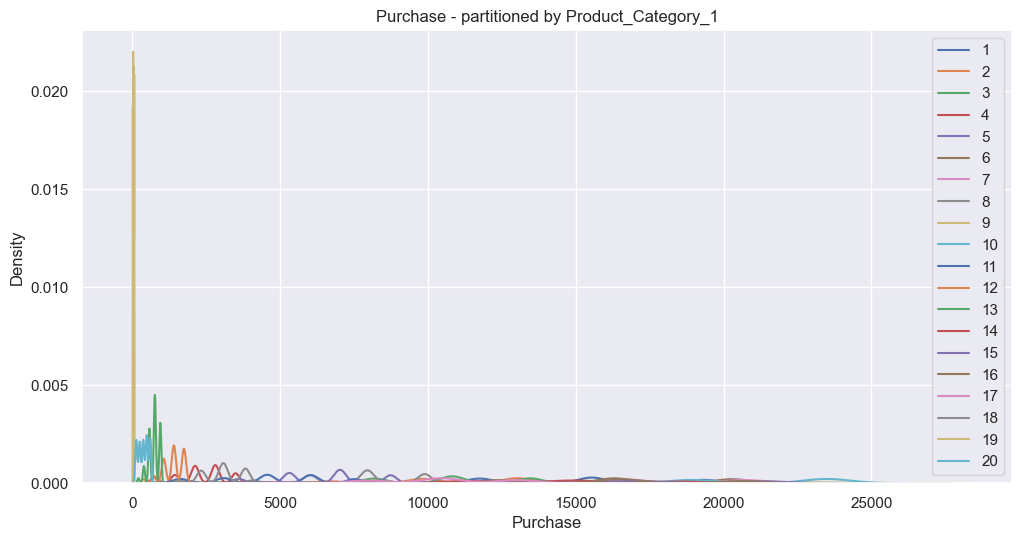

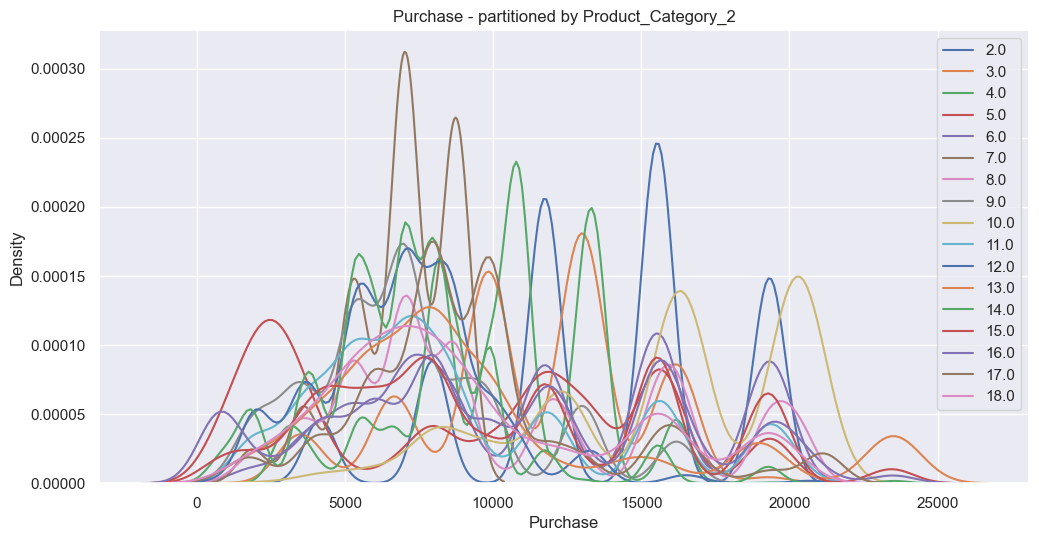

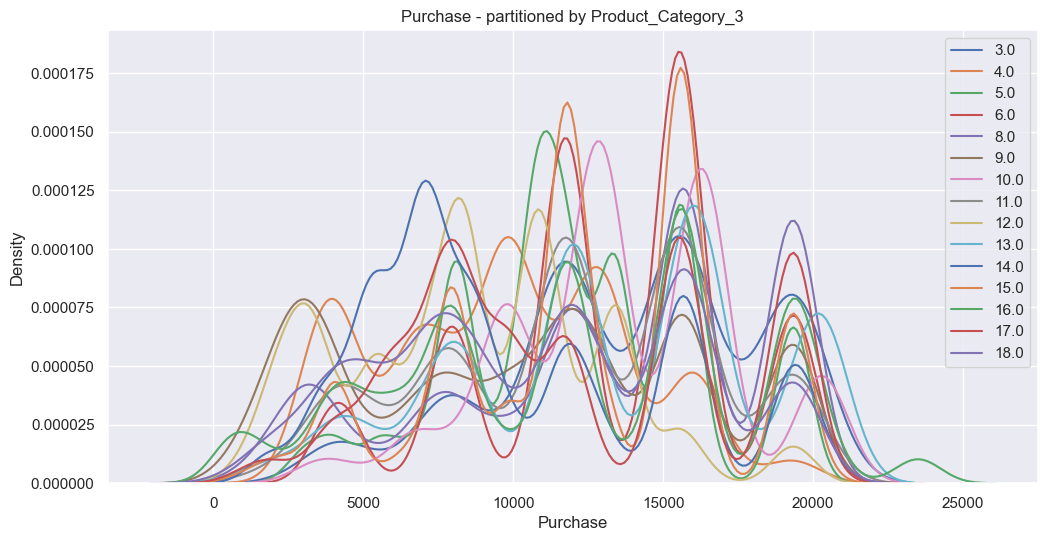

In [27]:
for feat_ in [
    # 'Gender', 'Age', 'Occupation', 'Marital_Status',
    # 'City_Category', 'Stay_In_Current_City_Years',
    'Product_Category_1', 'Product_Category_2', 'Product_Category_3'
]:
    trace_partitioned(train_data, y='Purchase', partition_by=feat_)

All the distributions of `Purchase` when partitioned by different values of the categorical features chosen overlap with one another.
<br>It suggests that such categorical feature - at least in a standalone manner - do not seem informative for the `Purchase`.

No feature chosen does not have any power in a standalone way to separate the values of `Purchase`, then to predict it accurately.

However such remark can be weighted down for `Product_Category_1` which may be more informative than the other features.

_CAUTION: do not try to interpret the y-axis as the plots refer to a `KDE-fitting`._

#### Important note

A more detailed exploration of all potential features against the `Purchase` is possible but tedious.

At this stage, we do not think that one feature could present itself and in a standalone way informative for the target variable. Then it is not worth the try to formulate any hypothesis and check it with some statistical test.

_One such hypothesis could have been: "`Marital_Status` does not influence `Purchase`", which could have been checked by running a Welch test.
<br>Another hypothesis could have been: "`Occupation` does not influence `Purchase`", which could have been checked by running an ANOVA test._

## Test data exploration

This section aims at making a batch of data explorations on the test dataset and highlighting the potential discrepancies.

Run some EDA similarly to the train dataset.
The test data size is a 9 MB CSV file.

In [28]:
# TODO: Upload data to GCS
test_data = pd.read_csv('D:/Data/BlackFriday/test.csv')
test_data.shape

(233599, 11)

In [32]:
print(f"The test represents {test_data.shape[0] / train_data.shape[0] * 100:.0f}% of the train data.")

The test represents 42% of the train data.


In [29]:
test_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


Use the same types for variables as the train dataset.

In [38]:
test_data[categorical_variables] = test_data[categorical_variables].astype('object')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)

Report test_report.html was generated.



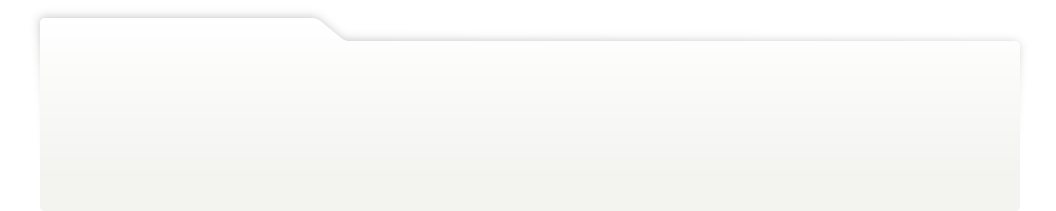
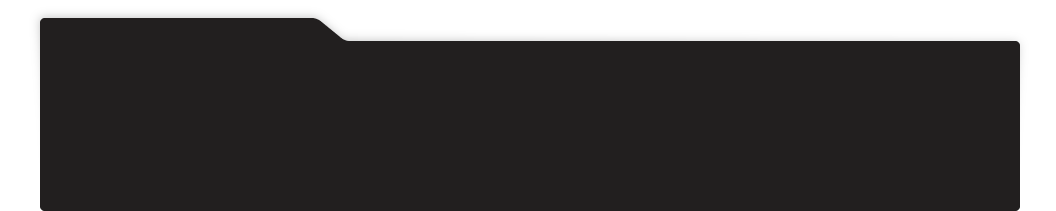
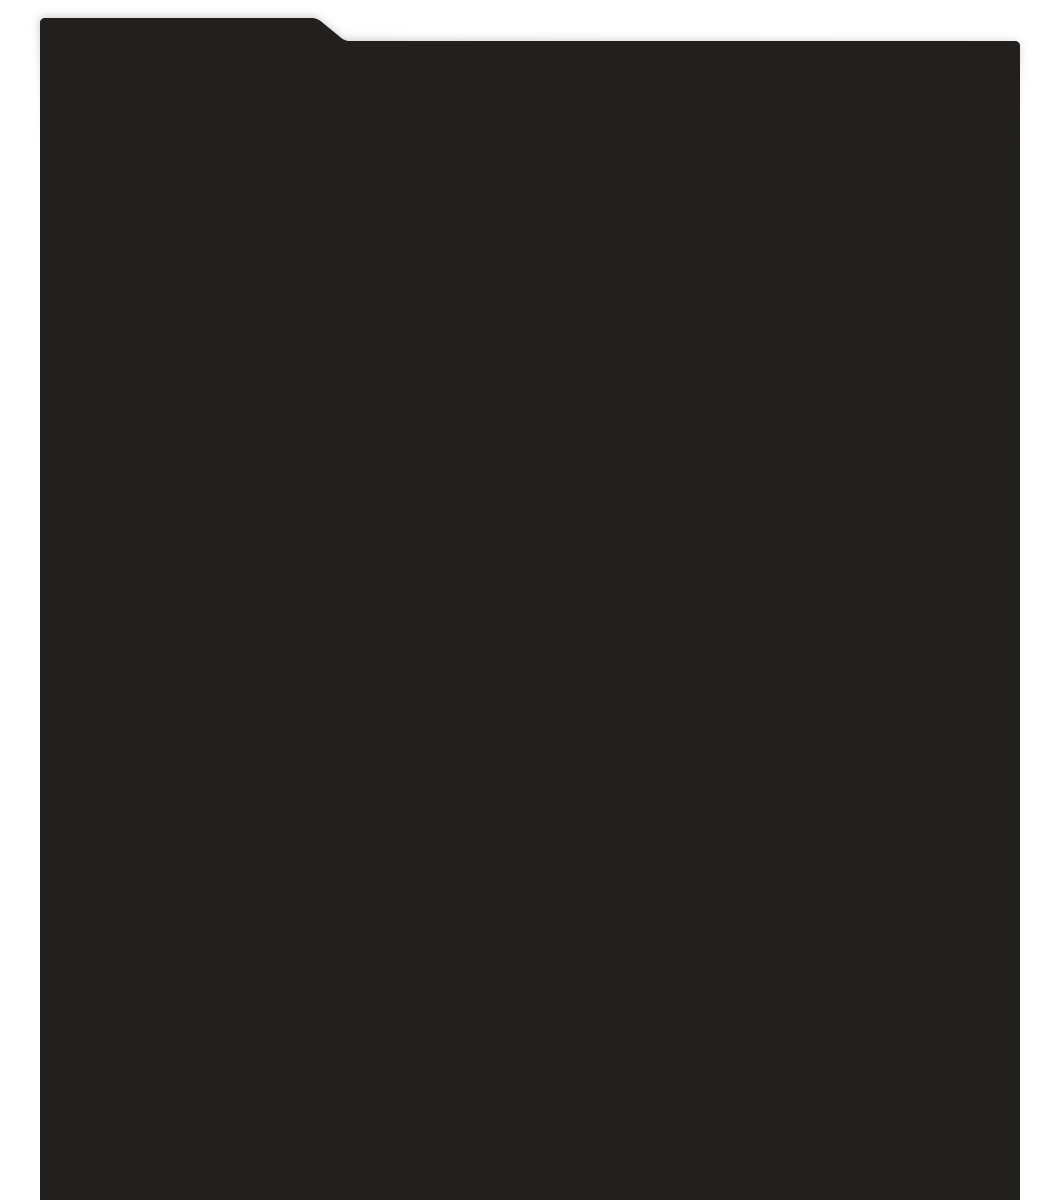
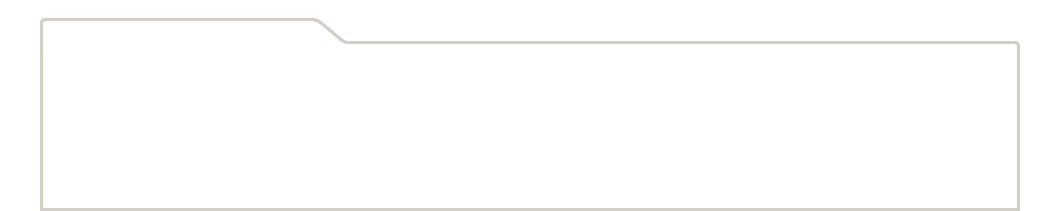
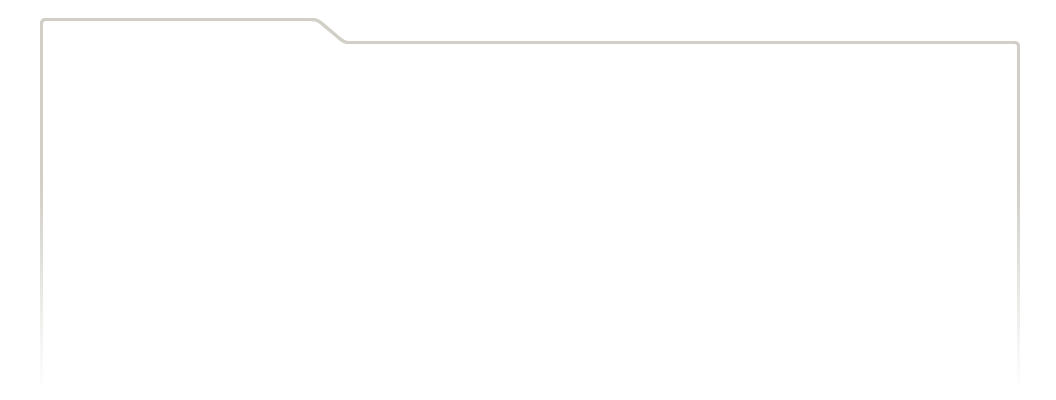
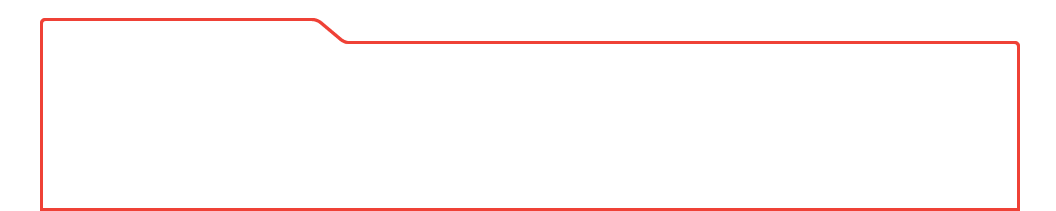
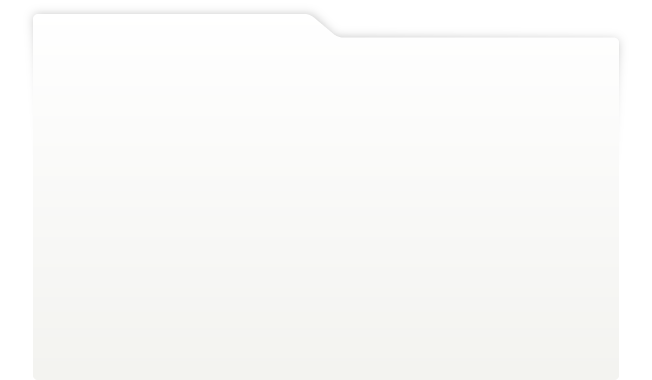
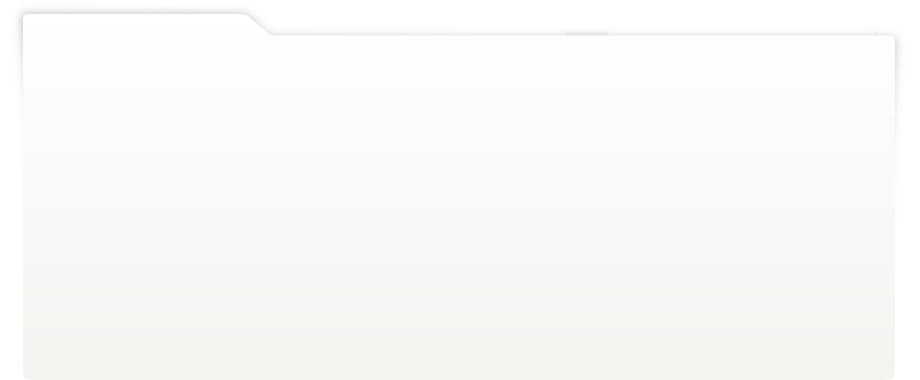
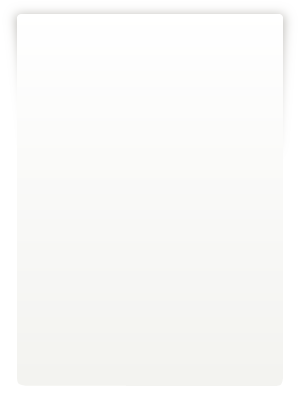
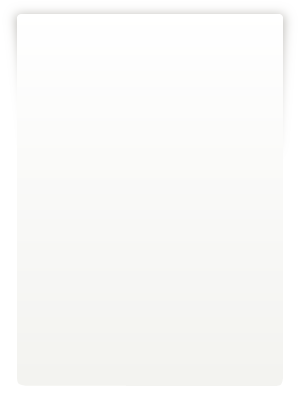
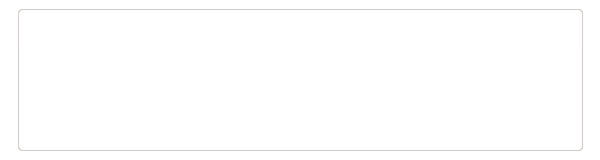
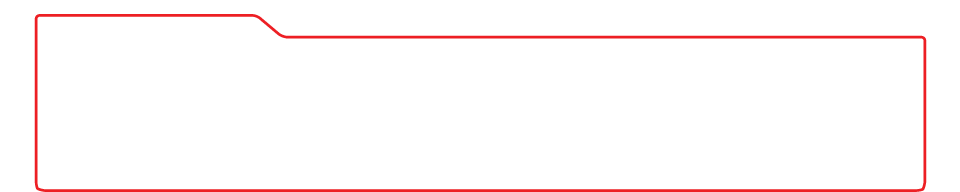
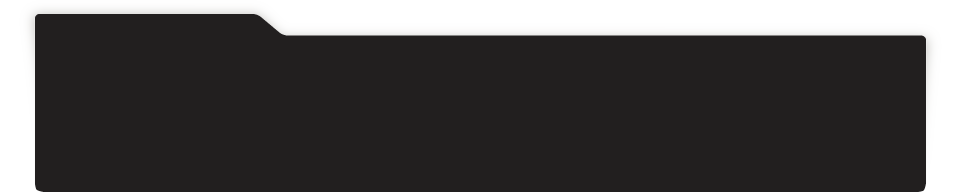
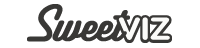
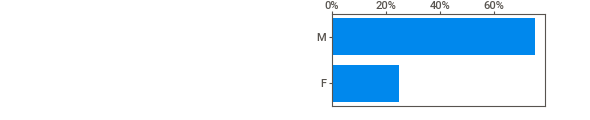
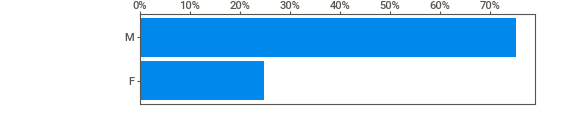
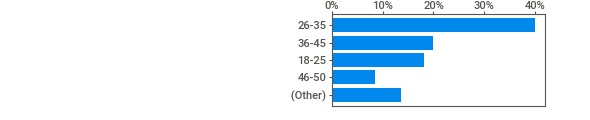
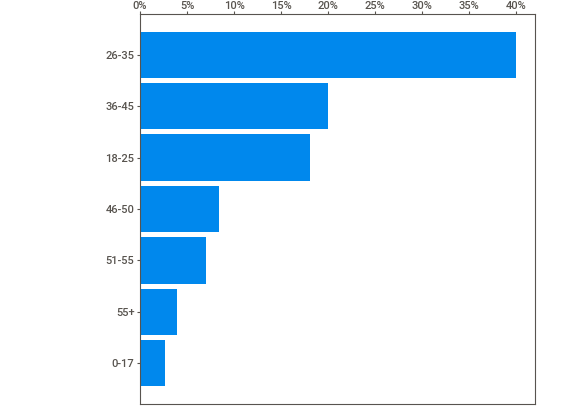
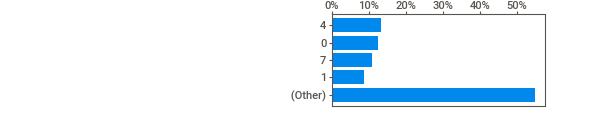
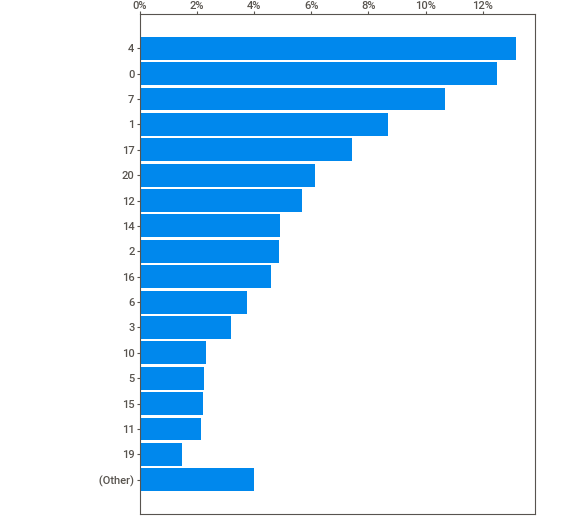
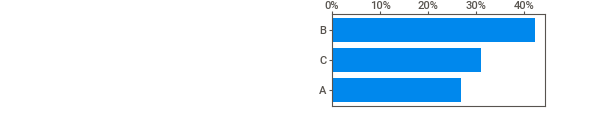
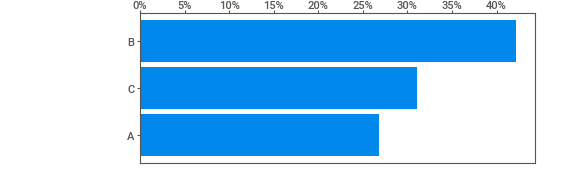
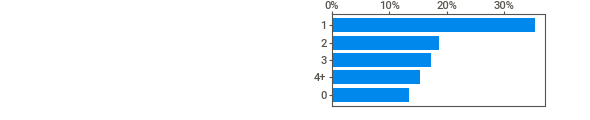
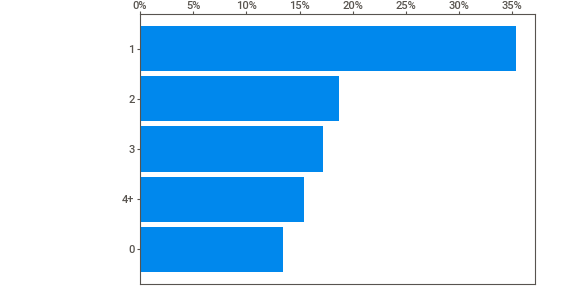
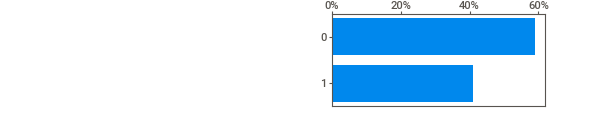
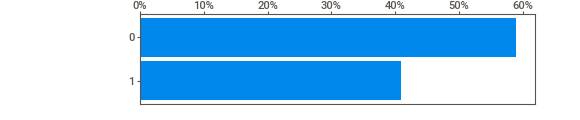
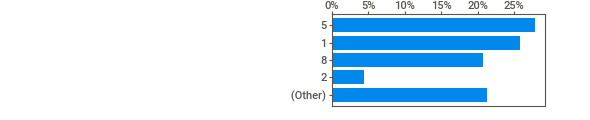
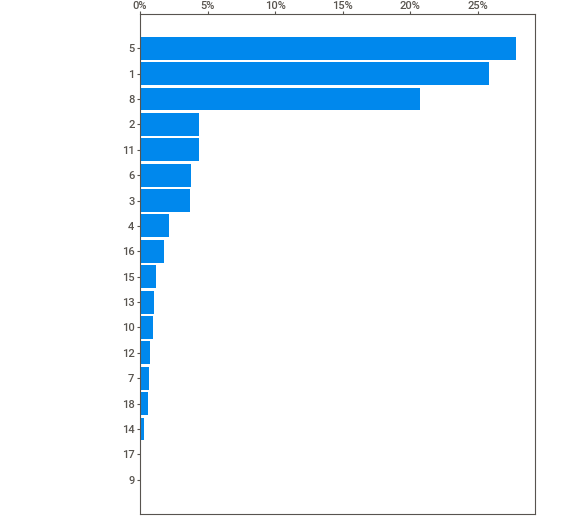
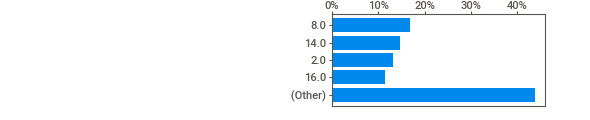
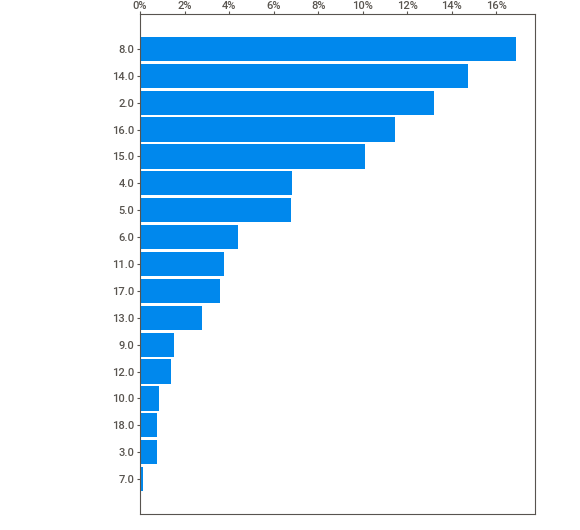
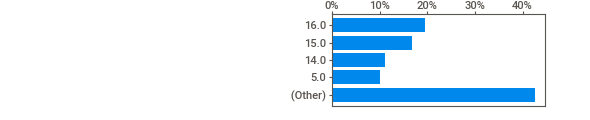
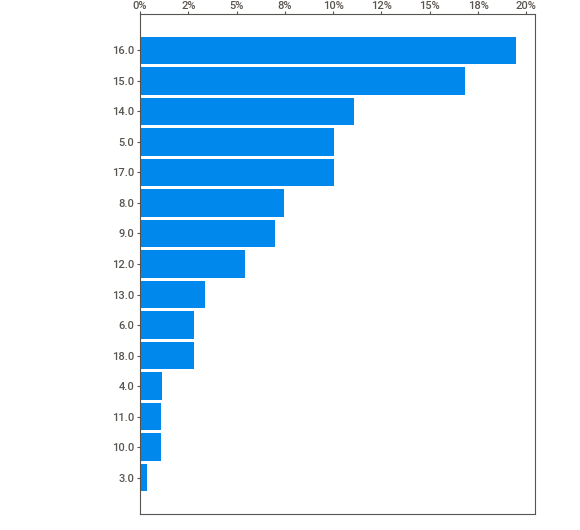
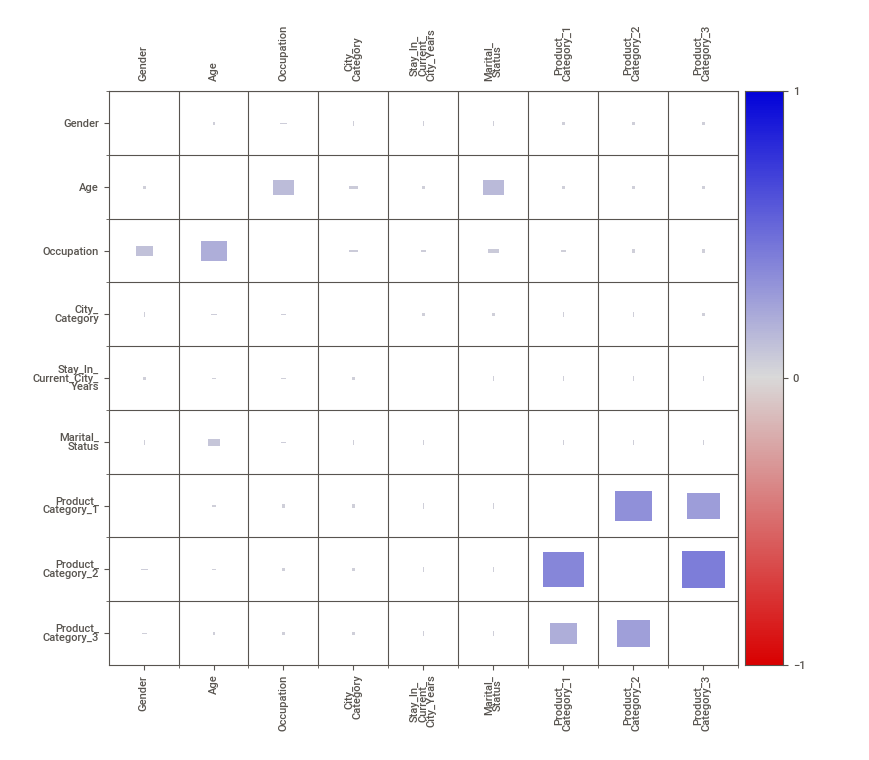
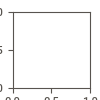

In [39]:
test_report = sweetviz.analyze([test_data, "Test"])

# Save report in a seperate file as well
test_report.show_html(filepath="test_report.html", open_browser=False)
test_report.show_notebook()